# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

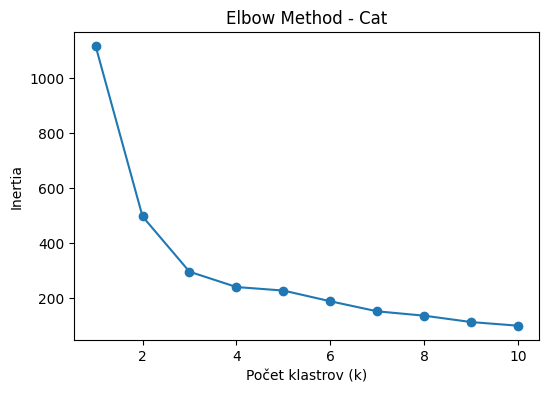

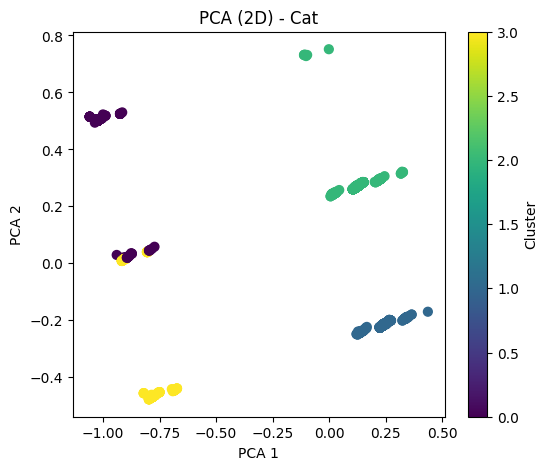

C:\Users\stefa\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(
C:\Users\stefa\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(
C:\Users\stefa\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(
C:\Users\stefa\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on

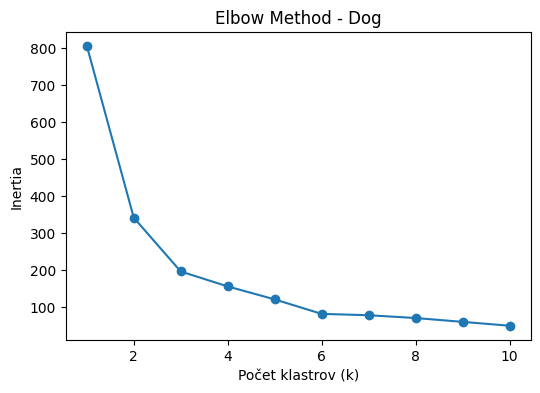

C:\Users\stefa\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


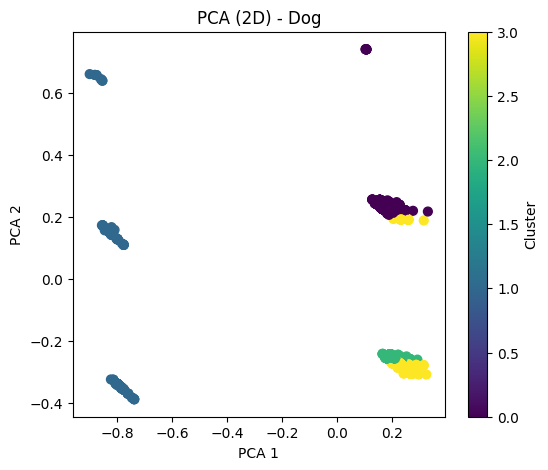

C:\Users\stefa\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\stefa\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\stefa\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\stefa\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Wi

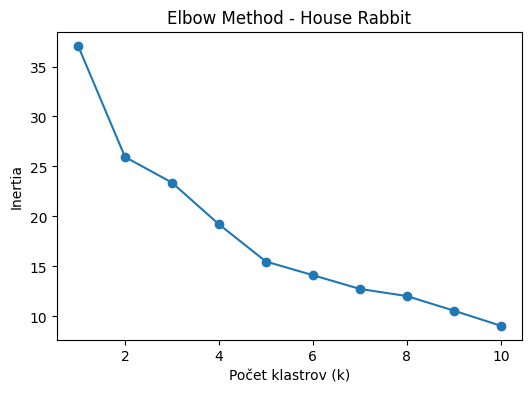

C:\Users\stefa\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


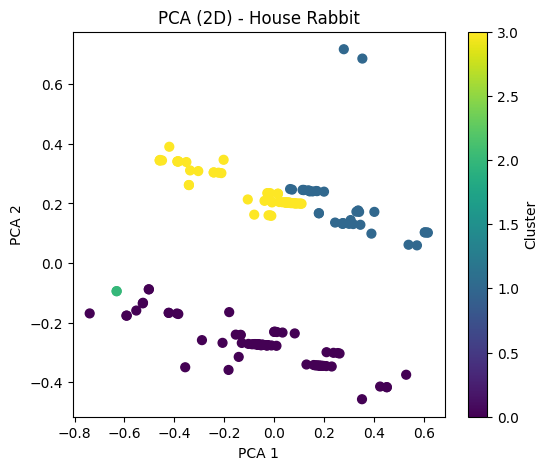


=== Výsledky pre druh: Cat ===
          animalage  sexname intakereason  stay_duration  adoption_cycles  \
Cluster                                                                     
0        130.316832  Unknown        Stray       8.524752         0.103960   
1         29.060827   Female        Stray      36.595955         0.994526   
2         25.362815     Male        Stray      29.707876         0.992899   
3         41.892632   Female        Stray      12.567368         0.098947   

         has_chip final_status  
Cluster                         
0             0.0   In Shelter  
1             1.0      Adopted  
2             1.0      Adopted  
3             0.0   In Shelter  

=== Výsledky pre druh: Dog ===
         animalage sexname   intakereason  stay_duration  adoption_cycles  \
Cluster                                                                     
0        44.305184    Male          Stray      30.358455         0.904682   
1        75.238859    Male          Stray   

In [93]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# 1) Načítanie datasetu
file_path = r'C:\Users\stefa\Downloads\cleaned_animal_data.csv'
data = pd.read_csv(file_path)

# 2) Úprava základných stĺpcov: výpočet stay_duration, final_status, atď.

# Najskôr zistíme dátum prvého prijatia (min intakedate) pre každé zviera:
first_intake_date = data.groupby('id')['intakedate'].min().rename('first_intakedate')

# Pripojíme to do pôvodnej tabuľky (vytvorí nový stĺpec):
data = data.merge(first_intake_date, on='id', how='left')

def get_last_event_date(row):
    # Ak je deceaseddate neprázdne, použijeme to, inak movementdate
    if pd.notnull(row['deceaseddate']):
        return row['deceaseddate']
    else:
        return row['movementdate']

data['last_event_date'] = data.apply(get_last_event_date, axis=1)

# Prevod stĺpcov na datetime
data['first_intakedate'] = pd.to_datetime(data['first_intakedate'])
data['last_event_date']   = pd.to_datetime(data['last_event_date'])

# stay_duration v dňoch
data['stay_duration'] = (data['last_event_date'] - data['first_intakedate']).dt.days

def determine_final_status(row):
    # 1) Ak je v movementtype = 'Adoption', zviera je adoptované
    if row.get('movementtype') == 'Adoption':
        return 'Adopted'

    # 2) Skontrolujeme, či reálne zomrelo / bolo utratené
    if pd.notnull(row.get('deceaseddate')):
        return 'Deceased'
    elif isinstance(row.get('deceasedreason'), str) and \
         any(x in row['deceasedreason'].lower() for x in ['died in care', 'uu', 'euthan', 'unable to treat']):
        return 'Deceased'
    elif row.get('puttosleep', 0) == 1:
        return 'Deceased'

    # 3) Inak "In Shelter"
    return 'In Shelter'

data['final_status'] = data.apply(determine_final_status, axis=1)

# Počet cyklov adopcie
adoption_cycles = data[data['movementtype'] == 'Adoption'].groupby('id').size()
data['adoption_cycles'] = data['id'].map(adoption_cycles).fillna(0)

# Indikátor mikročipu
data['has_chip'] = data['identichipnumber'].apply(
    lambda x: 1 if pd.notnull(x) and str(x).strip().lower() not in ['unknown', '0', 'nan', ''] else 0
)

# 3) Výber 3 najpočetnejších druhov
top_3_species = data['speciesname'].value_counts().head(3).index
data = data[data['speciesname'].isin(top_3_species)]

# 4) Zjednodušenie kategórií v intakereason
def simplify_intakereason(reason):
    if pd.isnull(reason):
        return 'Unknown'
    reason_lower = reason.lower()
    if any(x in reason_lower for x in
           ["incompatible", "unable to afford", "owner", "marriage", "landlord", "moving"]):
        return "Owner-related"
    else:
        return reason

data['intakereason'] = data['intakereason'].apply(simplify_intakereason)
data['intakereason'] = data['intakereason'].fillna('Unknown')

# 5) Agregácia na úroveň zvieraťa
aggregated_data = (
    data
    .groupby('id')
    .agg({
        'speciesname': 'first',
        'animalage': lambda x: x.iloc[0],  # ak to máte už v mesiacoch
        'sexname': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown',
        'intakereason': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown',
        'stay_duration': 'mean',
        'adoption_cycles': 'mean',
        'has_chip': 'max',
        'final_status': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown'
    })
    .reset_index()
)

def correct_short_stay_in_shelter(df, age_threshold=120, stay_threshold=7):
    """
    Pokiaľ zviera spĺňa:
     - animalage >= 120 (10+ rokov),
     - stay_duration <= 10 dní,
     - final_status == 'In Shelter',
    nastavíme mu final_status = 'Deceased'.
    """
    mask = (
        (df['animalage'] >= age_threshold) &
        (df['stay_duration'] <= stay_threshold) &
        (df['final_status'] == 'In Shelter')
    )
    df.loc[mask, 'final_status'] = 'Deceased'
    return df

aggregated_data = correct_short_stay_in_shelter(aggregated_data,
                                                age_threshold=120,
                                                stay_threshold=10)


# 6) Klastrovanie a vizualizácia pre každý druh
results = {}

for species in top_3_species:
    species_data = aggregated_data[aggregated_data['speciesname'] == species].copy()

    features = [
        'animalage',
        'sexname',
        'intakereason',
        'stay_duration',
        'adoption_cycles',
        'has_chip'
    ]
    clustering_data = species_data[features].copy()

    label_encoders = {}
    for col in ['sexname', 'intakereason']:
        le = LabelEncoder()
        clustering_data[col] = le.fit_transform(clustering_data[col].astype(str))
        label_encoders[col] = le

    clustering_data = clustering_data.fillna(0)

    scaler = MinMaxScaler()
    clustering_data_scaled = pd.DataFrame(
        scaler.fit_transform(clustering_data),
        columns=clustering_data.columns
    )

    inertia = []
    k_values = range(1, 11)
    for k in k_values:
        km = KMeans(n_clusters=k, random_state=42)
        km.fit(clustering_data_scaled)
        inertia.append(km.inertia_)

    plt.figure(figsize=(6, 4))
    plt.plot(k_values, inertia, marker='o')
    plt.title(f'Elbow Method - {species}')
    plt.xlabel('Počet klastrov (k)')
    plt.ylabel('Inertia')
    plt.show()

    optimal_k = 4  # manuálne zvolené
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    clusters = kmeans.fit_predict(clustering_data_scaled)
    clustering_data_scaled['Cluster'] = clusters

    results[species] = {
        'clustering_data': clustering_data_scaled,
        'original_data': species_data,
        'kmeans_model': kmeans
    }

    pca = PCA(n_components=2, random_state=42)
    pca_result = pca.fit_transform(clustering_data_scaled.drop(columns=['Cluster']))

    plt.figure(figsize=(6, 5))
    plt.scatter(pca_result[:, 0], pca_result[:, 1],
                c=clustering_data_scaled['Cluster'], cmap='viridis', s=40)
    plt.colorbar(label='Cluster')
    plt.title(f'PCA (2D) - {species}')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.show()


# 7) Výpis interpretácie klastrov
def majority_status_aggregator(status_series):
    """
    - Ak 'Deceased' tvorí nadpolovičnú väčšinu, vráti 'Deceased'.
    - Inak vráti najčastejšiu hodnotu (mode) zo status_series.
    """
    counts = status_series.value_counts()
    total = counts.sum()

    if 'Deceased' in counts and counts['Deceased'] > total / 2:
        # Deceased je väčšinový status v klastri
        return 'Deceased'
    else:
        # Inak zoberieme celkový modus
        return counts.idxmax()  # label s najväčším počtom

for species, info in results.items():
    print(f"\n=== Výsledky pre druh: {species} ===")
    cluster_data = info['clustering_data']
    summary_df = info['original_data'].copy()
    summary_df['Cluster'] = cluster_data['Cluster'].values

    cluster_summary = summary_df.groupby('Cluster').agg({
        'animalage': 'mean',
        'sexname': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown',
        'intakereason': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown',
        'stay_duration': 'mean',
        'adoption_cycles': 'mean',
        'has_chip': 'mean',
        'final_status': majority_status_aggregator
    })

    print(cluster_summary)
